In [ ]:
import os

import torch
import torchvision
import torch.nn as nn

import numpy as np
import pandas as pd

import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.utils.data import random_split
from torchvision.utils import make_grid

from PIL import Image
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Loading the Dataset

In [ ]:
data_dir = '/kaggle/input/100-bird-species'
paths_df = pd.read_csv(os.path.join(data_dir, "birds.csv"))
# The dataset as of 9-Jan-2023 contains a file that is 
# present at the given index whose dimension is not 224x224. Removing the file to avoid unnecessary complexity in the code
paths_df.drop(46620, axis= 0, inplace=True)
paths_df.head()

class id                      filepaths           labels  \
0         0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER   
1         0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER   
2         0  train/ABBOTTS BABBLER/003.jpg  ABBOTTS BABBLER   
3         0  train/ABBOTTS BABBLER/004.jpg  ABBOTTS BABBLER   
4         0  train/ABBOTTS BABBLER/005.jpg  ABBOTTS BABBLER   

       scientific label data set  
0  Malacocincla abbotti    train  
1  Malacocincla abbotti    train  
2  Malacocincla abbotti    train  
3  Malacocincla abbotti    train  
4  Malacocincla abbotti    train

In [ ]:
paths_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75125 entries, 0 to 75125
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   class id          75125 non-null  int64 
 1   filepaths         75125 non-null  object
 2   labels            75125 non-null  object
 3   scientific label  75125 non-null  object
 4   data set          75125 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


## Preparing the Data

Collecting the labels and mapping the labels to the birds name

In [ ]:
# unique() function finds the unique elements
#of an array and returns these unique elements as a sorted array.
labels = paths_df["class id"].unique()
bird_name_map = {int(i): paths_df[paths_df["class id"] == i]["labels"].values[0] for i in labels}

In [ ]:
print(labels)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [ ]:
print(bird_name_map)

{0: 'ABBOTTS BABBLER', 1: 'ABBOTTS BOOBY', 2: 'ABYSSINIAN GROUND HORNBILL', 3: 'AFRICAN CROWNED CRANE', 4: 'AFRICAN EMERALD CUCKOO', 5: 'AFRICAN FIREFINCH', 6: 'AFRICAN OYSTER CATCHER', 7: 'AFRICAN PIED HORNBILL', 8: 'ALBATROSS', 9: 'ALBERTS TOWHEE', 10: 'ALEXANDRINE PARAKEET', 11: 'ALPINE CHOUGH', 12: 'ALTAMIRA YELLOWTHROAT', 13: 'AMERICAN AVOCET', 14: 'AMERICAN BITTERN', 15: 'AMERICAN COOT', 16: 'AMERICAN FLAMINGO', 17: 'AMERICAN GOLDFINCH', 18: 'AMERICAN KESTREL', 19: 'AMERICAN PIPIT', 20: 'AMERICAN REDSTART', 21: 'AMERICAN WIGEON', 22: 'AMETHYST WOODSTAR', 23: 'ANDEAN GOOSE', 24: 'ANDEAN LAPWING', 25: 'ANDEAN SISKIN', 26: 'ANHINGA', 27: 'ANIANIAU', 28: 'ANNAS HUMMINGBIRD', 29: 'ANTBIRD', 30: 'ANTILLEAN EUPHONIA', 31: 'APAPANE', 32: 'APOSTLEBIRD', 33: 'ARARIPE MANAKIN', 34: 'ASHY STORM PETREL', 35: 'ASHY THRUSHBIRD', 36: 'ASIAN CRESTED IBIS', 37: 'ASIAN DOLLARD BIRD', 38: 'AUCKLAND SHAQ', 39: 'AUSTRAL CANASTERO', 40: 'AUSTRALASIAN FIGBIRD', 41: 'AVADAVAT', 42: 'AZARAS SPINETAIL', 43

<BarContainer object of 3 artists>

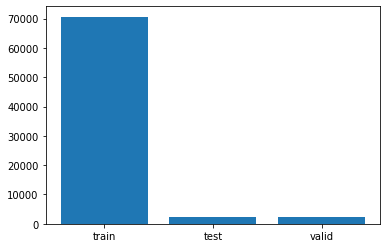

In [ ]:
dataset_split = paths_df["data set"].value_counts()
plt.bar(dataset_split.index, dataset_split.values)

 Collecting all the names of the birds from the names of the directories

In [ ]:
classes = os.listdir(data_dir + "/train")

Plots 20 different random images from the dataset every time it runs from any of the 450 classes

In [ ]:
def show_images(dataset='train'):
    # Parameters for our graph; we'll output images in a 5x4 configuration
    nrows = 5
    ncols = 4

    fig = plt.gcf()
    fig.set_size_inches(ncols * 5, nrows * 5)
    for i in range(20):
        name=random.choice(classes)
        next_pix=(os.path.join(data_dir,dataset,name))
        img = mpimg.imread(os.path.join(next_pix,random.choice(os.listdir(next_pix))))
        # Set up subplot; subplot indices start at 1
        sp = plt.subplot(nrows, ncols, i + 1)
        sp.axis('Off') # Don't show axes (or gridlines)
        plt.imshow(img)
        plt.title(name)

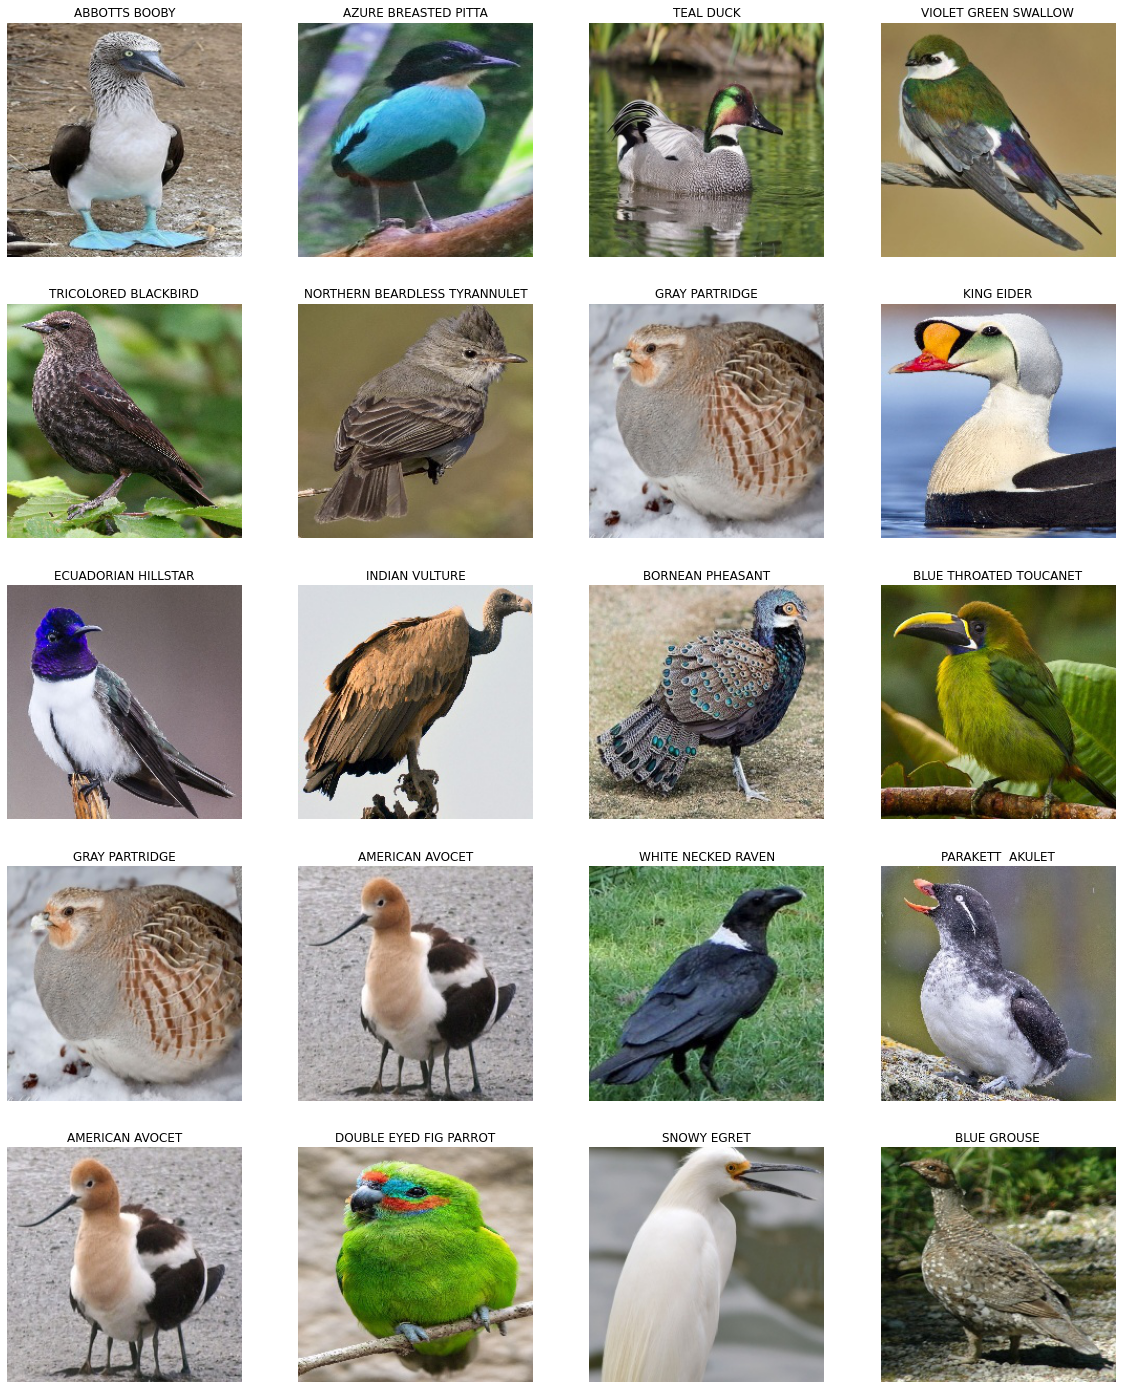

In [ ]:
show_images('test')

Creating dataloaders and converting to tensors for calculation of mean and std.

In [ ]:
dataset = ImageFolder(data_dir+'/valid', transform=T.ToTensor())
dataloader = DataLoader(dataset, batch_size=400)

Calculating the mean and std of the images for normalization.

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    print(channels_sum,channels_squared_sum,num_batches)
    return mean, std

In [ ]:
print(get_mean_and_std(dataloader))

tensor([2.8535, 2.8159, 2.3342]) tensor([1.6991, 1.6365, 1.2807]) 6
(tensor([0.4756, 0.4693, 0.3890]), tensor([0.2388, 0.2291, 0.2492]))


### Data augmentations

Transforming images to tensor, Normalizing the images from the mean and std calculated, and performing different kinds of data augmentation for the training set.

For the validation and test set images are transformed to tensors and the images are normalized.

In [ ]:
bird_stats = ([0.4758, 0.4685, 0.3870], [0.2376, 0.2282, 0.2475])

train_tfms = T.Compose([
    T.RandomCrop(224, padding=4, padding_mode='reflect'),
#     T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
     T.RandomApply(torch.nn.ModuleList([T.GaussianBlur(kernel_size=3,sigma=(0.2, 5))]),p=0.15),
    T.RandomHorizontalFlip(), 
    T.RandomRotation(10),
    T.ToTensor(), 
    T.Normalize(*bird_stats,inplace=True), 
])

valid_tfms = T.Compose([
    T.Resize(224), 
    T.ToTensor(), 
    T.Normalize(*bird_stats,inplace=True)
])

Class for applying the image transformations and converting the labels to tensors for model training

In [ ]:
class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepaths']
        img_path = os.path.join(data_dir, img_path)
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
        label = self.df.iloc[idx]['class id']
        
        label = torch.tensor(label, dtype=torch.long)
        return img, label

Applying the transformations on the images and creating dataloaders.

In [ ]:
train_df = paths_df[paths_df['data set'] == 'train']
test_df = paths_df[paths_df['data set'] == 'test']
val_df = paths_df[paths_df['data set'] == 'valid']

train_dataset = BirdDataset(train_df, train_tfms)
test_dataset = BirdDataset(test_df, valid_tfms)
val_dataset = BirdDataset(val_df, valid_tfms)

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=3)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=70, shuffle=True, num_workers=2)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Plotting a batch of dataset to check the images after the transformations.

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *bird_stats)
        ax.imshow(make_grid(denorm_images, nrow=16).permute(1, 2, 0).clamp(0,1))
        break

Making grid of a batch to check the dataset

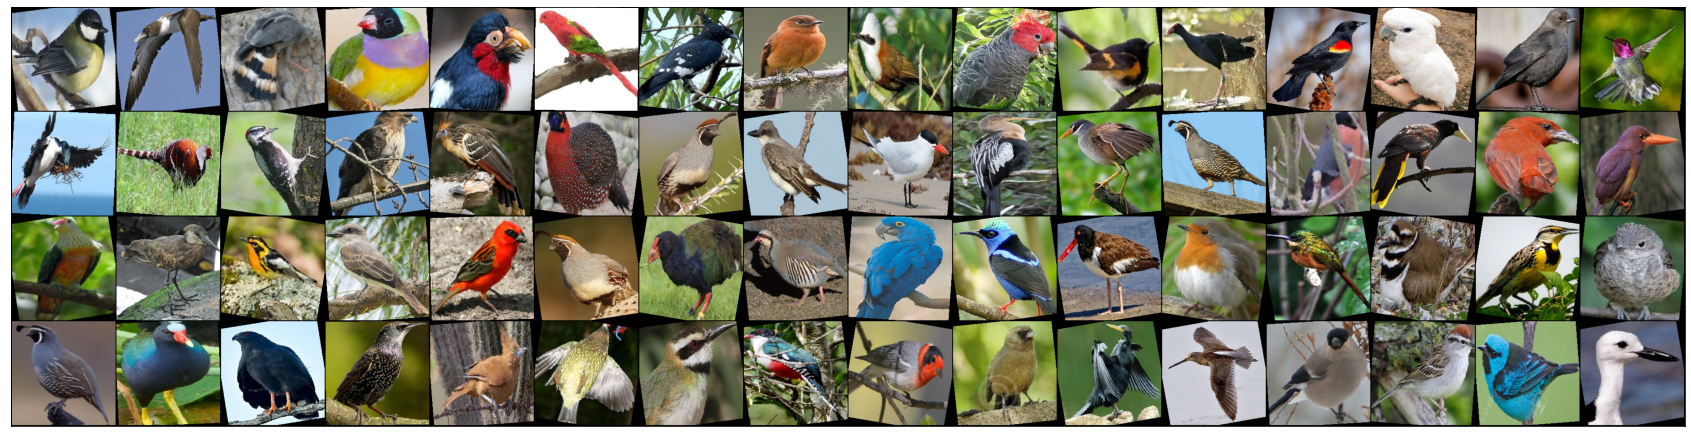

In [ ]:
show_batch(train_dl)

Checking the Device available and moving the model and dataset to that device using these functions

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Checking the Device available.

In [ ]:
device = get_default_device()
device

device(type='cuda')

Moving the dataset to the device available.

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl,device)

Defining functions for calculating accuracy and Loss

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)  
        return loss,acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, last_lr: {:.5f}".format(
            epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc'], result['lrs'][-1]))

Designing the custom residual model.

In [ ]:
def conv_block(in_channels, out_channels, activation=False, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels)]
    if activation: layers.append(nn.ReLU(inplace=True))
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet34(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=4),
            nn.BatchNorm2d(64),nn.MaxPool2d(2),nn.ReLU(inplace=True))
           
        self.res1 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res2 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res3 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.downsample1=nn.Sequential(conv_block(64, 128,pool=True)) 
        self.res4 = nn.Sequential(conv_block(64, 128,activation=True, pool=True),
                                  conv_block(128,128))
        self.res5 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res6 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res7 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res8 = nn.Sequential(conv_block(128, 256,activation=True, pool=True),
                                  conv_block(256,256))
        self.downsample2 = nn.Sequential(conv_block(128, 256,pool=True))
        self.res9 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res10 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res11 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res12 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res13 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res14 = nn.Sequential(conv_block(256, 512,activation=True, pool=True),
                                   conv_block(512,512))
        
        self.downsample3 = nn.Sequential(conv_block(256, 512,pool=True))
        self.res15 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512))
        self.res16 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512,activation=True))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.17),
                                        nn.Linear(512, num_classes))
        self.apply(self.init_weights)

    def init_weights(self,m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.res2(out) + out
        out = self.res3(out) + out
        out = self.downsample1(out) +self.res4(out)
        out = self.res5(out) + out
        out = self.res6(out) + out
        out = self.res7(out) + out
        out = self.downsample2(out) +self.res8(out)
        out = self.res9(out) + out
        out = self.res10(out) + out
        out = self.res11(out) + out
        out = self.res12(out) + out
        out = self.res13(out) + out
        out = self.downsample3(out) + self.res14(out) 
        out = self.res15(out) + out
        out = self.res16(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = ResNet34(3, 450)

Installing torchinfo for summary of the model.

In [ ]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from torchinfo import summary

summary(model, input_size=(64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet34                                 [64, 450]                 --
├─Sequential: 1-1                        [64, 64, 113, 113]        --
│    └─Conv2d: 2-1                       [64, 64, 226, 226]        9,472
│    └─BatchNorm2d: 2-2                  [64, 64, 226, 226]        128
│    └─MaxPool2d: 2-3                    [64, 64, 113, 113]        --
│    └─ReLU: 2-4                         [64, 64, 113, 113]        --
├─Sequential: 1-2                        [64, 64, 113, 113]        --
│    └─Sequential: 2-5                   [64, 64, 113, 113]        --
│    │    └─Conv2d: 3-1                  [64, 64, 113, 113]        36,928
│    │    └─BatchNorm2d: 3-2             [64, 64, 113, 113]        128
│    │    └─ReLU: 3-3                    [64, 64, 113, 113]        --
│    └─Sequential: 2-6                   [64, 64, 113, 113]        --
│    │    └─Conv2d: 3-4                  [64, 64, 113, 113]        36,928
│ 

In [ ]:
model

ResNet34(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU(inplace=True)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (res2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
 

Importing the [resnet-34 model](https://github.com/Moddy2024/ResNet-34) that I have trained from scratch on CIFAR-10 dataset and acheived an accuracy of 94.5% across 10 different classes.

In [ ]:
model2 = to_device(ResNet34(3, 10), device)
model2.load_state_dict(torch.load('/kaggle/input/resnet34trainedmodel/resnet34best.pth'))

<All keys matched successfully>

Cutting out the Fully connected layer of the pretrained model and creating the new fully connected layer

In [ ]:
class BirdResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Using the pretrained model
        self.network = model2
        # Replace last layer
        num_ftrs = model2.classifier[3].in_features
        model2.classifier[3] = nn.Linear(num_ftrs, 450)
    
    def forward(self, xb):
        return (self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

Defining the evaluation function, updating the changed learning rate for the optimizer function and the fit function for backpropagation and model training.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,weight_decay=0, 
        bias_clip=False,grad_clip=None, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func
    best_accuracy=0.00000
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer
                                                ,eta_min=0.00001,T_max=epochs*len(train_loader))
    for epoch in (range(epochs)):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy= []
        lrs=[]
        for (batch_idx, batch) in enumerate(train_loader):
            loss,accuracy = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accuracy)
            loss.backward()
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            # Bias Clipping
            # Made my custom bias clipping model because clip_grad_value clips both the weigths and biases but we need a smaller value for bias
            if bias_clip:
                params=model.state_dict()
                for name, param in model.named_parameters():
                    if 'bias' in name:
                        # Access the biases
                        params[name][:]=torch.clip(param, min=-0.09, max=0.09)
                model.load_state_dict(params)
            optimizer.step()
            optimizer.zero_grad()
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
            if batch_idx % 552 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.4f}'.
                format(epoch+1, batch_idx , len(train_loader),
                       100. * batch_idx / len(train_loader), loss,accuracy))
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        if result['val_acc']>best_accuracy:
            torch.save(model.state_dict(), '/kaggle/working/bird-resnet34best.pth')
            best_accuracy=result['val_acc']
    return history

Initialising the model.

In [ ]:
modelbird = to_device(BirdResnet(), device)
modelbird

512


BirdResnet(
  (network): ResNet34(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(4, 4))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): ReLU(inplace=True)
    )
    (res1): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (res2): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

## Checking the accuracy of model before training
Accuracy on the validation dataset

In [ ]:
evaluate(modelbird, valid_dl)

{'val_loss': 7.111220836639404, 'val_acc': 0.0008658008882775903}

Accuracy on the test dataset.

In [ ]:
evaluate(modelbird, test_dl)

{'val_loss': 7.116893291473389, 'val_acc': 0.0026041667442768812}

Unfreeze the ResNet layers this trains all the layers to start classifying the images.

In [ ]:
modelbird.unfreeze()

Stating the no. of epochs, learning rate, value for gradient clipping, value for weight decay, choosing if bias clip is going to be used or not and choosing the optimizer.

In [ ]:
epochs = 30
max_lr = 0.001
grad_clip = 0.8
weight_decay = 0.0001
bias_clip=True
opt_func = torch.optim.Adam(modelbird.parameters(),max_lr,amsgrad=True
                            , weight_decay=weight_decay)

In [ ]:
%%time
history = fit_one_cycle(epochs, max_lr, modelbird, train_dl, valid_dl, 
                             grad_clip=grad_clip,
                            bias_clip=bias_clip,
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Train Epoch: 1 [0/1104 (0%)]	Loss: 9.243227, Accuracy: 0.0000
Train Epoch: 1 [552/1104 (50%)]	Loss: 4.856492, Accuracy: 0.0312
Epoch [1], train_loss: 4.8194, train_acc: 0.0864, val_loss: 3.1326, val_acc: 0.2714, last_lr: 0.00100
Train Epoch: 2 [0/1104 (0%)]	Loss: 3.601640, Accuracy: 0.1875
Train Epoch: 2 [552/1104 (50%)]	Loss: 2.738918, Accuracy: 0.3281
Epoch [2], train_loss: 2.6187, train_acc: 0.4042, val_loss: 1.6513, val_acc: 0.6000, last_lr: 0.00099
Train Epoch: 3 [0/1104 (0%)]	Loss: 1.768428, Accuracy: 0.5625
Train Epoch: 3 [552/1104 (50%)]	Loss: 1.463190, Accuracy: 0.6719
Epoch [3], train_loss: 1.6440, train_acc: 0.6064, val_loss: 1.0812, val_acc: 0.7221, last_lr: 0.00098
Train Epoch: 4 [0/1104 (0%)]	Loss: 1.545593, Accuracy: 0.6250
Train Epoch: 4 [552/1104 (50%)]	Loss: 1.633045, Accuracy: 0.5938
Epoch [4], train_loss: 1.2379, train_acc: 0.6951, val_loss: 0.7964, val_acc: 0.8004, last_lr: 0.00096
Train Epoch: 5 [0/1104 (0%)]	Loss: 1.364300, Accuracy: 0.6719
Train Epoch: 5 [552/11

Functions for plotting accuracy, loss and learning rate change.

In [ ]:
def plot_accuracies(history):
    train_accuracies= [x['train_accuracy'] for x in history]
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.plot(train_accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Validation','Training'])
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');


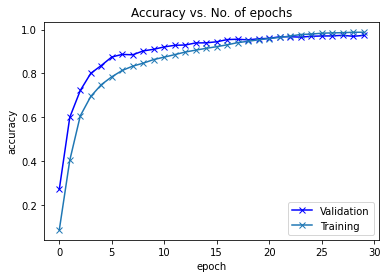

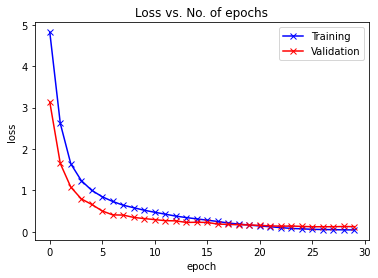

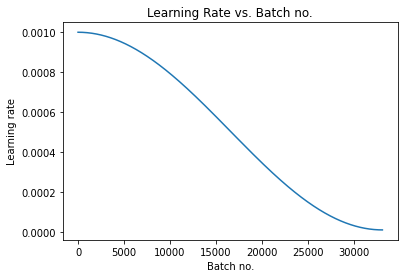

In [ ]:
plot_accuracies(history)
plt.show()
plot_losses(history)
plt.show()
plot_lrs(history)

Function for prediction of a image.

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    model.eval()
    with torch.no_grad():
        yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    
    return bird_name_map.get(preds[0].item())

Prediction of a single image

Label: AMETHYST WOODSTAR , Predicted: AMETHYST WOODSTAR


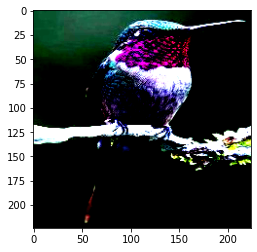

In [ ]:
img, label = val_dataset[110]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', bird_name_map.get(label.item()) , ', Predicted:', predict_image(img, modelbird))

Label: SPOONBILL , Predicted: SPOONBILL


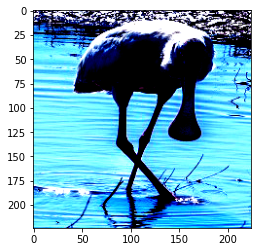

In [ ]:
img, label = val_dataset[2000]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', bird_name_map.get(label.item()) , ', Predicted:', predict_image(img, modelbird))

Label: GOLDEN PARAKEET , Predicted: GOLDEN PARAKEET


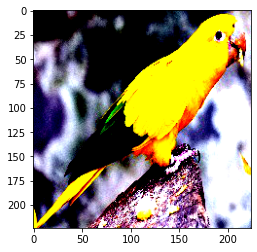

In [ ]:
img, label = val_dataset[1100]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', bird_name_map.get(label.item()) , ', Predicted:', predict_image(img, modelbird))

Label: GREY PLOVER , Predicted: GREY PLOVER


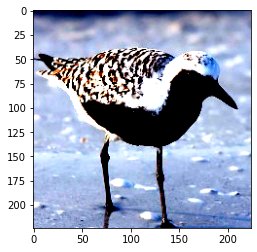

In [ ]:
img, label = test_dataset[1200]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', bird_name_map.get(label.item()) , ', Predicted:', predict_image(img, modelbird))

Saving the model

In [ ]:
torch.save(modelbird.state_dict(), '/kaggle/working/bird-resnet34.pth')

Loading the model for Sanity Check.

In [ ]:
model4 = to_device(BirdResnet(), device)
model4.load_state_dict(torch.load('/kaggle/working/bird-resnet34.pth'))

512


<All keys matched successfully>

In [ ]:
evaluate(model4, valid_dl)

{'val_loss': 0.125839963555336, 'val_acc': 0.9731600284576416}

In [ ]:
evaluate(model4, test_dl)

{'val_loss': 0.06867159903049469, 'val_acc': 0.9813067317008972}

Loading the best model for sanity check

In [ ]:
modelbest=to_device(BirdResnet(), device)
modelbest.load_state_dict(torch.load('/kaggle/working/bird-resnet34best.pth'))

512


<All keys matched successfully>

In [ ]:
evaluate(modelbest, valid_dl)

{'val_loss': 0.12424270063638687, 'val_acc': 0.9735930562019348}

In [ ]:
evaluate(modelbest, test_dl)

{'val_loss': 0.06998986750841141, 'val_acc': 0.9811047315597534}

Saving a checkpoint of the model

In [ ]:
torch.save({
            'epoch': epochs,
            'model_state_dict': modelbird.state_dict(),
            'optimizer_state_dict': opt_func.state_dict(),
            #'loss': train_loss,
            
            }, '/kaggle/working/bird-checkpoint.tar')